# K-nearest neigbours

In [1]:

import time
import numpy as np

# sklearn
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

# visualization
import matplotlib.pyplot as plt
import seaborn

# torch
import torch
from torchvision import datasets, transforms

print(torch.cuda.is_available())
print(torch.version.cuda)

False
12.1


/home/gian/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


#### First lets load [MNIST data](http://yann.lecun.com/exdb/mnist/)

In [12]:
mnist_train_dataset = datasets.MNIST('', train=True, download=True)
mnist_test_dataset = datasets.MNIST('', train=False, download=True)

print("MNIST train dataset shape:", mnist_train_dataset.data.shape)
print("MNIST test dataset shape:", mnist_test_dataset.data.shape)

MNIST train dataset shape: torch.Size([60000, 28, 28])
MNIST test dataset shape: torch.Size([10000, 28, 28])


#### Lets visualize some data

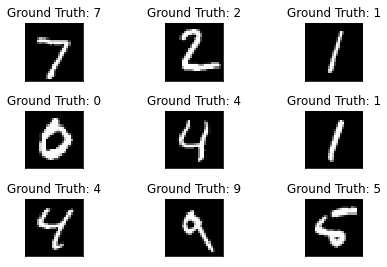

In [13]:
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(mnist_test_dataset.data[i], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(mnist_test_dataset.targets[i]))
  plt.xticks([])
  plt.yticks([])

In [55]:
def knn_param_search(train_data, train_labels, test_data, test_labels, 
                     metrics=('manhattan', 'euclidean', 'chebyshev'), 
                     ks=(1, 3, 5, 10, 25, 50, 100, 250), 
                     n_train=None, n_test=None, algorithm='brute'):
  """
  Takes a dataset and plots knn classification accuracy 
  for different hyper parameters.

  n_train and n_test allows to subsample the dataset for faster iteration
  """
  x_train = np.array(train_data)
  y_train = np.array(train_labels)
  x_test = np.array(test_data)
  y_test = np.array(test_labels)
  
  # flatten images, eg (N, H, W, C) -> (N, H * W * C)
  d_data = np.prod(x_train.shape[1:])
  x_train, x_test = x_train.reshape(-1, d_data), x_test.reshape(-1, d_data)
  # make sure y is a flat list (N,)
  y_train, y_test = y_train.reshape(-1), y_test.reshape(-1)
  # subsample the dataset
  if n_train:
    x_train, y_train = x_train[:n_train], y_train[:n_train]
  if n_test:
    x_test, y_test = x_test[:n_test], y_test[:n_test]

  for metric in metrics:
    print(f'Metric: {metric}')
    for k in ks:
        print(f'\tk: {k:3d} Training', end='')
        classifier = neighbors.KNeighborsClassifier(k, algorithm=algorithm, metric=metric)
        classifier = classifier.fit(x_train, y_train)

        start = time.time()
        print(f'\r\tk: {k:3d} Testing', end='')
        labels = classifier.predict(x_test)
        duration = time.time() - start

        correct = labels == np.array(y_test)
        print(f'\r\tk: {k:3d} Accuracy: {correct.mean() * 100:.2f} %, Duration: {duration:.2f} s')

In [34]:
knn_param_search(mnist_train_dataset.data, mnist_train_dataset.targets, 
                 mnist_test_dataset.data, mnist_test_dataset.targets, 
                 n_train=10000, n_test=500)

Metric: manhattan
	k:   1 Accuracy: 90.60 %, Duration: 3.94 s
	k:   3 Accuracy: 91.20 %, Duration: 3.97 s
	k:   5 Accuracy: 91.40 %, Duration: 3.98 s
	k:  10 Accuracy: 90.40 %, Duration: 3.96 s
	k:  25 Accuracy: 87.80 %, Duration: 3.97 s
	k:  50 Accuracy: 85.80 %, Duration: 3.98 s
	k: 100 Accuracy: 83.80 %, Duration: 3.99 s
	k: 250 Accuracy: 77.80 %, Duration: 3.99 s
Metric: euclidean
	k:   1 Accuracy: 92.20 %, Duration: 0.32 s
	k:   3 Accuracy: 92.40 %, Duration: 0.35 s
	k:   5 Accuracy: 91.80 %, Duration: 0.37 s
	k:  10 Accuracy: 91.80 %, Duration: 0.38 s
	k:  25 Accuracy: 91.00 %, Duration: 0.38 s
	k:  50 Accuracy: 87.20 %, Duration: 0.37 s
	k: 100 Accuracy: 85.80 %, Duration: 0.38 s
	k: 250 Accuracy: 80.80 %, Duration: 0.39 s
Metric: chebyshev
	k:   1 Accuracy: 66.20 %, Duration: 6.41 s
	k:   3 Accuracy: 64.80 %, Duration: 6.40 s
	k:   5 Accuracy: 71.40 %, Duration: 6.45 s
	k:  10 Accuracy: 68.20 %, Duration: 6.42 s
	k:  25 Accuracy: 66.40 %, Duration: 6.40 s
	k:  50 Accuracy: 64.6

In [35]:
# Use all data to evaluate performance of the most promising hyperparameters
(x_train, y_train) = (mnist_train_dataset.data, mnist_train_dataset.targets) 
(x_test, y_test) = (mnist_test_dataset.data, mnist_test_dataset.targets) 

classifier = neighbors.KNeighborsClassifier(3, algorithm='brute', metric='euclidean')
classifier = classifier.fit(x_train.reshape((-1, 28 * 28)), y_train)
labels = classifier.predict(x_test.reshape((-1, 28 * 28)))

correct = labels == np.array(y_test)
print(f'Accuracy: {correct.mean() * 100} %')

Accuracy: 97.05 %


It may come as a surprise that it works so well.
Let's spend a little time examining our model and data.

In [72]:
def show_nearest_neighbours(train_data, train_labels, test_data, test_labels,
                            n_examples=20, n_neighbours=10, seed=None, 
                            scale=1., labelnames=tuple(range(10))):
  x_train = np.array(train_data)
  y_train = np.array(train_labels)
  x_test = np.array(test_data)
  y_test = np.array(test_labels)

  rand = np.random.RandomState(seed=seed)
  idx = rand.randint(0, len(x_test), n_examples)
  x_test, y_test = x_test[idx], y_test[idx].reshape(-1)
  y_train = y_train.reshape(-1)

  d_data = np.prod(x_test.shape[1:])
  classifier = neighbors.KNeighborsClassifier(algorithm='brute', metric='euclidean')
  classifier = classifier.fit(x_train.reshape((-1, d_data)), y_train)
  dist, idx = classifier.kneighbors(x_test[:n_examples].reshape(-1, d_data), 
                                    n_neighbors=n_neighbours)

  fig, axs = plt.subplots(n_neighbours + 1, n_examples, 
                          figsize=(n_examples * 0.5 * scale, 
                                   n_neighbours * 0.75 * scale))
  cmap = 'gray' if len(x_test.shape) == 3 else None
  for i in range(n_examples):
    ax = axs[0, i]
    ax.imshow(x_test[i], cmap=cmap)
    ax.set_title(labelnames[y_test[i]])
    if i == 0:
      ax.set_ylabel('inp')
    for j in range(n_neighbours):
      ax = axs[j + 1, i]
      n_idx = idx[i, j]
      y = y_train[n_idx]
      ax.imshow(x_train[n_idx], cmap=cmap)
      ax.set_title(labelnames[y] if y != y_test[i] else '')
      if i == 0:
        ax.set_ylabel(f'n{j+1}')
  for ax in axs.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
  plt.tight_layout()

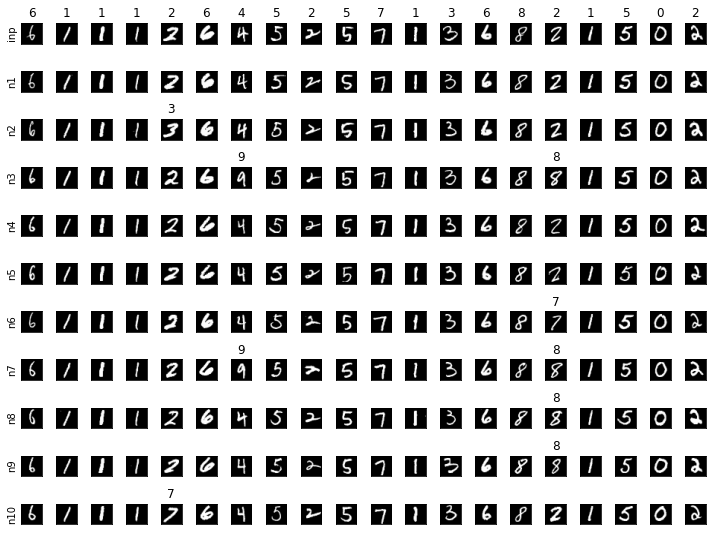

In [37]:
show_nearest_neighbours(mnist_train_dataset.data, mnist_train_dataset.targets, 
                        mnist_test_dataset.data, mnist_test_dataset.targets, 
                        seed=0)

Looking at the nearest neighbours, it becomes apparent that for many of the test images, an almost identical image is in the training set.

To us, the nearest neighbour 'mistakes' (n1-n10 with another marked number) may seem odd, but remember that the distance is meassured in pixel space.

Let's have a look at what kind of mistakes the model makes.

In [43]:
def plot_confusion_matrix(gt, pred, only_show_mistakes=False, 
                          labelnames='auto'):
  gt = np.array(gt)
  pred = np.array(pred)
  if only_show_mistakes:
    mask = gt != pred
    gt, pred = gt[mask], pred[mask]

  conf_matrix = confusion_matrix(gt, pred)
  plt.figure(figsize=(10, 8))
  ax = seaborn.heatmap(conf_matrix / conf_matrix.sum(), annot=True, fmt='.2%', 
                       cmap='Blues', cbar=False, yticklabels=labelnames)
  ax.set_ylabel('ground truth')
  ax.set_xlabel('predicted')

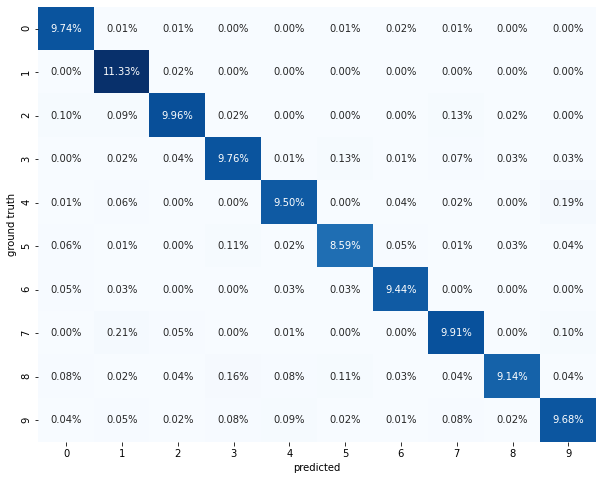

In [44]:
plot_confusion_matrix(y_test, labels)

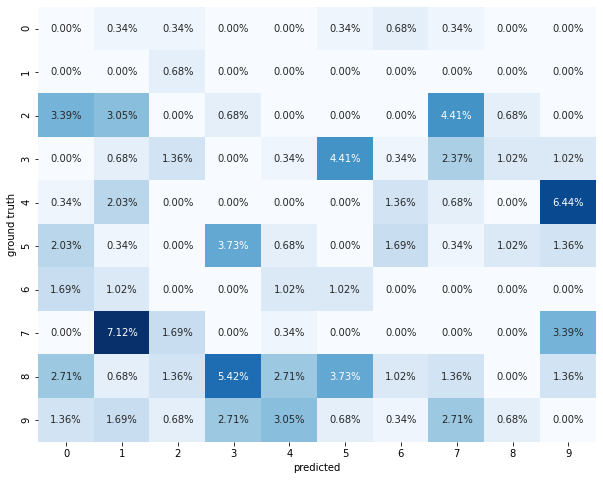

In [45]:
plot_confusion_matrix(y_test, labels, only_show_mistakes=True)

In [66]:
def show_mistake_examples(x_test, y_test, labels, labelnames=tuple(range(10)), 
                          rows=4, cols=7, seed=None):
  x_test = np.array(x_test)
  y_test = np.array(y_test)
  labels = np.array(labels)
  mask = labels != y_test
  x_test, y_test, labels = x_test[mask], y_test[mask], labels[mask]
  idx = np.random.RandomState(seed=seed).randint(0, len(x_test), rows * cols)
  x_test, y_test, labels = x_test[idx], y_test[idx], labels[idx]
  cmap = 'gray' if x_test.ndim == 3 else None
  fig, axs = plt.subplots(rows, cols, figsize=(cols, rows * 1.0))
  for i, ax in enumerate(axs.reshape(-1)):
    ax.imshow(x_test[i], cmap=cmap)
    gt, pred = labelnames[y_test[i]], labelnames[labels[i]]
    ax.set_title(f'{gt} ({pred})')
    ax.axis('off')
  plt.tight_layout()
  print('ground truth (predicted)')
  plt.show()

ground truth (predicted)


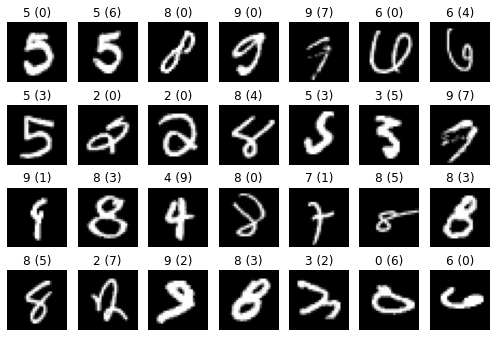

In [47]:
show_mistake_examples(x_test, y_test, np.array(labels))

# CIFAR 10

In [48]:
cifar10_train_dataset = datasets.CIFAR10('../', train=True, download=True)
cifar10_test_dataset = datasets.CIFAR10('../', train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../cifar-10-python.tar.gz to ../
Files already downloaded and verified


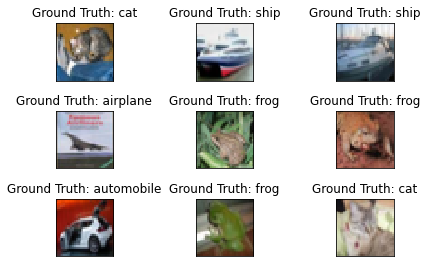

In [51]:
cifar10_classes = cifar10_train_dataset.classes
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(cifar10_test_dataset.data[i], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(cifar10_classes[cifar10_test_dataset.targets[i]]))
  plt.xticks([])
  plt.yticks([])

In [56]:
knn_param_search(cifar10_train_dataset.data, cifar10_train_dataset.targets, 
                 cifar10_test_dataset.data, cifar10_test_dataset.targets,
                 ['euclidean'], n_test=500)

Metric: euclidean
	k:   1 Accuracy: 32.80 %, Duration: 4.92 s
	k:   3 Accuracy: 31.60 %, Duration: 5.00 s
	k:   5 Accuracy: 32.80 %, Duration: 5.18 s
	k:  10 Accuracy: 33.40 %, Duration: 5.15 s
	k:  25 Accuracy: 32.00 %, Duration: 5.17 s
	k:  50 Accuracy: 31.40 %, Duration: 5.16 s
	k: 100 Accuracy: 28.80 %, Duration: 5.18 s
	k: 250 Accuracy: 27.60 %, Duration: 5.17 s


In [58]:
(x_train, y_train) = (cifar10_train_dataset.data, cifar10_train_dataset.targets)
(x_test, y_test) = (cifar10_test_dataset.data, cifar10_test_dataset.targets)

# Use all data to evaluate performance of the most promising hyperparameters
classifier = neighbors.KNeighborsClassifier(10, algorithm='brute', metric='euclidean')
classifier = classifier.fit(x_train.reshape((-1, 32 * 32 * 3)), y_train)
labels = classifier.predict(x_test.reshape((-1, 32 * 32 * 3)))
correct = labels == np.array(y_test)
print(f'Accuracy: {correct.mean() * 100} %')

Accuracy: 33.86 %


ground truth (predicted)


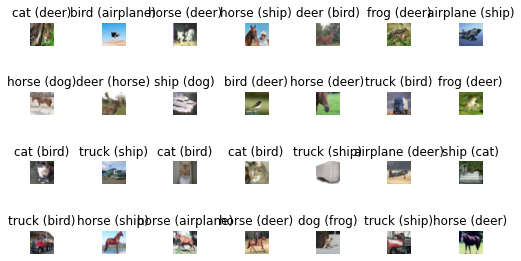

In [69]:
show_mistake_examples(x_test, y_test, labels, labelnames=cifar10_classes)

This doesn't work nearly as well as our MNIST classifier. Some of the predictions seem ridiculous. Let's look at the nearest neighbours.

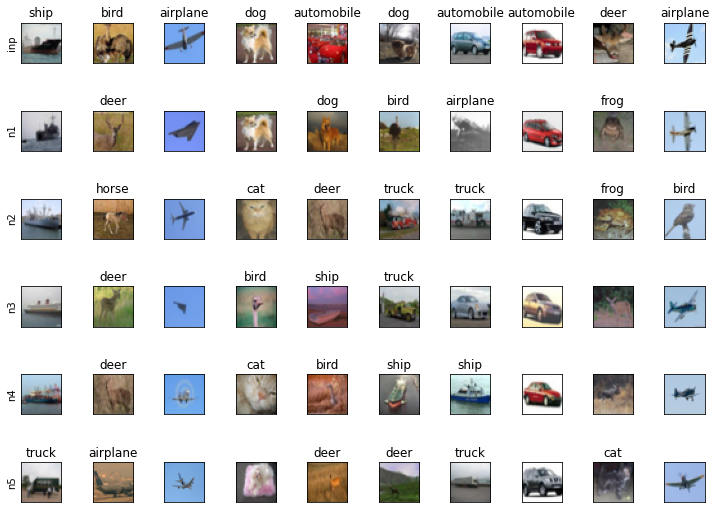

In [74]:
show_nearest_neighbours(cifar10_train_dataset.data, cifar10_train_dataset.targets,
                        cifar10_test_dataset.data, cifar10_test_dataset.targets,
                        n_examples=10, n_neighbours=5, scale=2, labelnames=cifar10_classes)

We could improve accuracy by gathering more data, but that's expensive.
Also note that inference time grows with the amount of training data.

# Principal Component Analysis (PCA)

Instead of measuring the distance directly in pixel-space,
we can attempt to extract features using a classical decomposition.

In [76]:
from sklearn.decomposition import PCA

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

d_pca = 20  # hyper parameter
pca = PCA(n_components=d_pca).fit(x_train.reshape((-1, 32 * 32 * 3)))
x_train_pca = pca.transform(x_train.reshape((-1, 32 * 32 * 3)))
x_test_pca = pca.transform(x_test.reshape((-1, 32 * 32 * 3)))
print(f'\tCIFAR-10 compressed train x/y shape: {x_train_pca.shape} / {y_train.shape}')
print(f'\tCIFAR-10 compressed test x/y shape: {x_test_pca.shape} / {y_test.shape}')

	CIFAR-10 compressed train x/y shape: (50000, 20) / (50000,)
	CIFAR-10 compressed test x/y shape: (10000, 20) / (10000,)


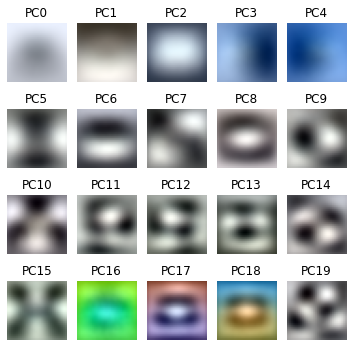

In [77]:
# we can visualize the pca components
fig, axs = plt.subplots(4, 5, figsize=(5, 5))
for i, ax in enumerate(axs.reshape(-1)):
  pci = pca.components_[i].reshape(32, 32, 3)
  ax.imshow(0.5 + pci * 0.5 / np.abs(pci).max())
  ax.set_title(f'PC{i}')
  ax.axis('off')
plt.tight_layout()

In [78]:
knn_param_search(x_train_pca, y_train, x_test_pca, y_test, n_test=500)

Metric: manhattan
	k:   1 Accuracy: 31.20 %, Duration: 0.37 s
	k:   3 Accuracy: 31.80 %, Duration: 0.47 s
	k:   5 Accuracy: 35.60 %, Duration: 0.64 s
	k:  10 Accuracy: 38.80 %, Duration: 0.64 s
	k:  25 Accuracy: 42.40 %, Duration: 0.63 s
	k:  50 Accuracy: 39.40 %, Duration: 0.64 s
	k: 100 Accuracy: 38.40 %, Duration: 0.63 s
	k: 250 Accuracy: 36.40 %, Duration: 0.65 s
Metric: euclidean
	k:   1 Accuracy: 31.40 %, Duration: 0.26 s
	k:   3 Accuracy: 33.80 %, Duration: 0.37 s
	k:   5 Accuracy: 36.60 %, Duration: 0.52 s
	k:  10 Accuracy: 37.80 %, Duration: 0.53 s
	k:  25 Accuracy: 38.40 %, Duration: 0.52 s
	k:  50 Accuracy: 38.80 %, Duration: 0.53 s
	k: 100 Accuracy: 38.00 %, Duration: 0.53 s
	k: 250 Accuracy: 37.40 %, Duration: 0.55 s
Metric: chebyshev
	k:   1 Accuracy: 28.40 %, Duration: 0.52 s
	k:   3 Accuracy: 28.80 %, Duration: 0.60 s
	k:   5 Accuracy: 30.00 %, Duration: 0.77 s
	k:  10 Accuracy: 32.40 %, Duration: 0.77 s
	k:  25 Accuracy: 34.20 %, Duration: 0.77 s
	k:  50 Accuracy: 34.2

In [79]:
classifier = neighbors.KNeighborsClassifier(25, algorithm='brute', metric='manhattan')
classifier = classifier.fit(x_train_pca, y_train)
labels = classifier.predict(x_test_pca)
correct = labels == y_test
print(f'Accuracy: {correct.mean() * 100} %')

Accuracy: 42.14 %
